# CIFAR-10_CNN
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<ipython-input-4-2181f8df30a5>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


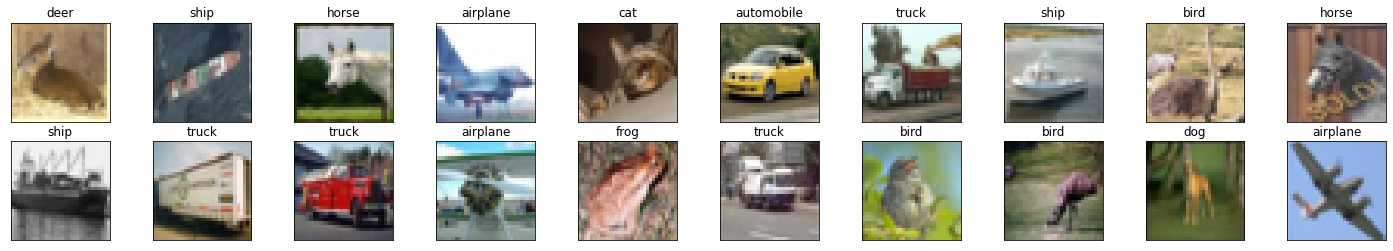

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

---
## Define the Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 512)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # linear layer (512 -> 128)
        self.fc2 = nn.Linear(512, 128)
        # linear layer (128 -> 10)
        self.fc3 = nn.Linear(128, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify Loss Function and Optimizer

In [6]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network


In [11]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.338029 	Validation Loss: 1.241038
Validation loss decreased (inf --> 1.241038).  Saving model ...
Epoch: 2 	Training Loss: 1.247930 	Validation Loss: 1.154200
Validation loss decreased (1.241038 --> 1.154200).  Saving model ...
Epoch: 3 	Training Loss: 1.167430 	Validation Loss: 1.092064
Validation loss decreased (1.154200 --> 1.092064).  Saving model ...
Epoch: 4 	Training Loss: 1.094919 	Validation Loss: 1.036483
Validation loss decreased (1.092064 --> 1.036483).  Saving model ...
Epoch: 5 	Training Loss: 1.033847 	Validation Loss: 0.973833
Validation loss decreased (1.036483 --> 0.973833).  Saving model ...
Epoch: 6 	Training Loss: 0.980509 	Validation Loss: 0.937445
Validation loss decreased (0.973833 --> 0.937445).  Saving model ...
Epoch: 7 	Training Loss: 0.929972 	Validation Loss: 0.904083
Validation loss decreased (0.937445 --> 0.904083).  Saving model ...
Epoch: 8 	Training Loss: 0.883817 	Validation Loss: 0.874221
Validation loss decreased (0.90408

###  Load the Model with the Lowest Validation Loss

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

In [13]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.733916

Test Accuracy of airplane: 78% (788/1000)
Test Accuracy of automobile: 83% (837/1000)
Test Accuracy of  bird: 64% (646/1000)
Test Accuracy of   cat: 56% (569/1000)
Test Accuracy of  deer: 73% (732/1000)
Test Accuracy of   dog: 51% (519/1000)
Test Accuracy of  frog: 83% (836/1000)
Test Accuracy of horse: 79% (799/1000)
Test Accuracy of  ship: 89% (892/1000)
Test Accuracy of truck: 84% (843/1000)

Test Accuracy (Overall): 74% (7461/10000)


### Visualize Sample Test Results

<ipython-input-14-a0724321e9b1>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


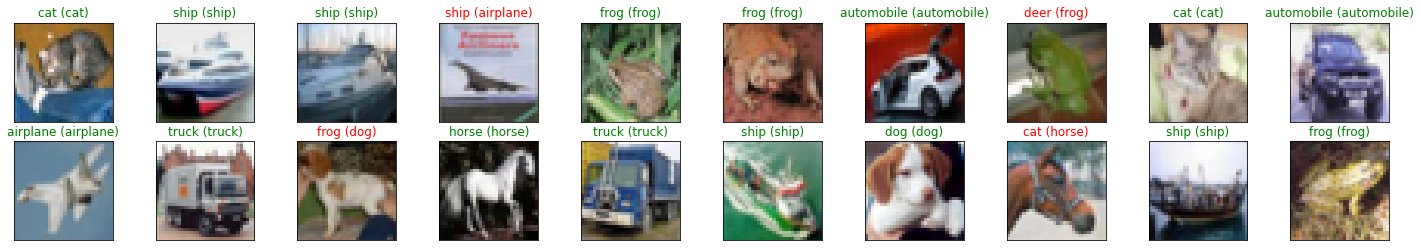

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))